In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from mycnn import LeNet5

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape 784 to 28x28x1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# pad image from 28x28x1 to 32x32x1
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)))
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)))
print(x_train.shape)
print(x_test.shape)

# convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [24]:
lenet5 = LeNet5(
    input_shape=(32,32,1),
    classes_num=10,
    weights_path="./log_lenet5/weights.h5"
)
# lenet5.setup_logfile("./log_lenet5")
# lenet5.load_checkpoint()

[Info] Pre-trained weights: ./log_lenet5/weights.h5


In [25]:
data_id = 0

pr_data = x_test[data_id:data_id+1,...]  # only choice one data
# plt.imshow(pr_data[0,:,:,0])
# plt.show()

pr_sc = lenet5.predict(pr_data)
pr_lb = pr_sc.argmax(axis=-1)
print("Score:")
print(pr_sc[0])
print("Label:", pr_lb[0])


[Info] Use `tf.keras.Model` method predict

Score:
[4.7882072e-06 1.0943578e-06 6.2853818e-05 5.4065742e-05 8.0601694e-08
 6.2486902e-07 5.3041121e-10 9.9986446e-01 4.1062179e-07 1.1651517e-05]
Label: 7


(1, 32, 32, 1)


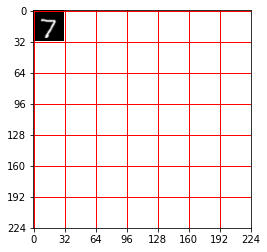

In [5]:
# assert os.path.exists(img_path) == True
# img = image.load_img(img_path, target_size=(256,256), grayscale=True)
# img_tensor = image.img_to_array(img)

img_tensor = pr_data
print(img_tensor.shape)
plt.imshow(img_tensor[0,:,:,0],cmap='gray')
plt.xticks(range(0,256,32))
plt.yticks(range(0,256,32))
plt.grid(color='r', linestyle='-', linewidth=1)
plt.show()

## [DEV] search conv and pool layer

In [22]:
# assert os.path.exists(MODEL_DIR) == True
# print('Load previous training.\n')
# model = DNN(INPUT_SIZE, MODEL_DIR)

model = lenet5.model

model.layers[0]

layer_outputs = [layer.output for layer in model.layers[1:31]]
for op in layer_outputs:
    print(op.__class__)
    print(op.shape, op)

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
print(len(activations))
first_layer_activation = activations[0]
print(first_layer_activation.shape)

<class 'keras.engine.keras_tensor.KerasTensor'>
(None, 28, 28, 6) KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 6), dtype=tf.float32, name=None), name='conv2d/Tanh:0', description="created by layer 'conv2d'")
<class 'keras.engine.keras_tensor.KerasTensor'>
(None, 14, 14, 6) KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 6), dtype=tf.float32, name=None), name='average_pooling2d/AvgPool:0', description="created by layer 'average_pooling2d'")
<class 'keras.engine.keras_tensor.KerasTensor'>
(None, 10, 10, 16) KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 16), dtype=tf.float32, name=None), name='conv2d_1/Tanh:0', description="created by layer 'conv2d_1'")
<class 'keras.engine.keras_tensor.KerasTensor'>
(None, 5, 5, 16) KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 16), dtype=tf.float32, name=None), name='average_pooling2d_1/AvgPool:0', description="created by layer 'average_pooling2d_1'")
<class 'keras.engine.keras_tensor.KerasTensor'>
(None, 400) KerasTensor(ty

In [26]:
FM_LIST = [tf.keras.layers.Conv2D, tf.keras.layers.MaxPool2D, tf.keras.layers.AveragePooling2D]

layer_outputs = []
for layer in model.layers:
    if layer.__class__ in FM_LIST:
        print(layer.__class__)
        op = layer.output
        if len(op.shape) == 4:
            print(op.shape)
            layer_outputs.append(op)

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
print(len(activations))
first_layer_activation = activations[0]
print(first_layer_activation.shape)

<class 'keras.layers.convolutional.Conv2D'>
(None, 28, 28, 6)
<class 'keras.layers.pooling.AveragePooling2D'>
(None, 14, 14, 6)
<class 'keras.layers.convolutional.Conv2D'>
(None, 10, 10, 16)
<class 'keras.layers.pooling.AveragePooling2D'>
(None, 5, 5, 16)
4
(1, 28, 28, 6)


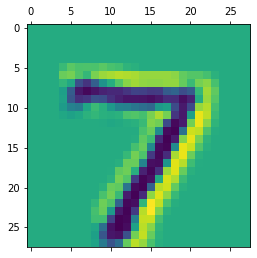

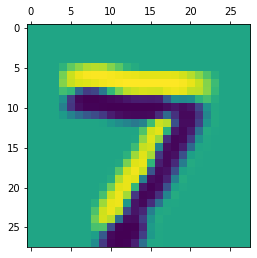

In [27]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

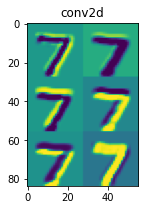

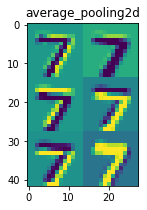

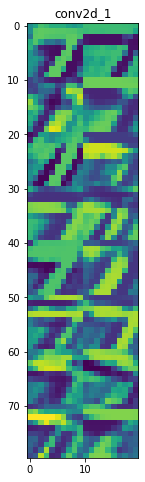

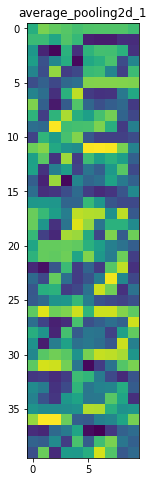

In [49]:
from PIL import Image

layer_names = []

for layer in model.layers[1:5]:
    layer_names.append(layer.name)

images_per_row = 2

cnt = 0
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()
    savefig = np.abs(display_grid)/np.abs(np.max(display_grid)) * 255
    
    save_dir = r'output\visualization'
    if not(os.path.exists(save_dir)):
        os.makedirs(save_dir)
        
    H, W = savefig.shape
    savefig = savefig.reshape(H, W).astype("uint8")
    image = Image.fromarray(savefig)
    image.save(r'%s\%d_%s.bmp'%(save_dir,cnt,layer_name))

    cnt += 1